In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/preprocessed_file_v0_filtered', 
                 compression = "zip", header = 0, index_col = 0, sep = "\t")

In [4]:
data = df.drop("CANCER_TYPE", axis = 1)
labels = df["CANCER_TYPE"]

In [5]:
print(labels.unique(), len(labels.unique()))

['Glioma' 'Leukemia' 'Thyroid Cancer' 'Hepatobiliary Cancer'
 'Mature B-Cell Neoplasms' 'Non-Small Cell Lung Cancer'
 'Soft Tissue Sarcoma' 'Pancreatic Cancer' 'Head and Neck Cancer'
 'Esophagogastric Cancer' 'Melanoma' 'Breast Cancer' 'Endometrial Cancer'
 'Colorectal Cancer' 'Prostate Cancer' 'Renal Cell Carcinoma'
 'Bladder Cancer' 'Ovarian Cancer'] 18


In [6]:
encoder = preprocessing.LabelEncoder()
classes = encoder.fit_transform(labels)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
									data, classes, 
									test_size = 0.2, 
									random_state = 0) 

print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)

(78067,)
(78067, 1345)
(19517,)
(19517, 1345)


In [23]:
learning_rate = 0.1
opt = 'ADAM'
lambda_l1 = 0.001
size_batch = 256
nb_epochs = 50

In [24]:
#3rd try: add l1 regularizers 

model = Sequential()	
	
model.add(	
	Dense(64, input_dim = len(data.columns), activation = 'relu',
	      kernel_regularizer = regularizers.l1(lambda_l1)))

model.add(	
	Dense(32, activation = 'relu',
	      kernel_regularizer = regularizers.l1(lambda_l1)))

model.add(	
	Dense(16, activation = 'relu',
	      kernel_regularizer = regularizers.l1(lambda_l1)))
	
model.add(	
	Dense(len(labels.unique()), activation = 'softmax',
	      kernel_regularizer = regularizers.l1(lambda_l1)))
	
model.compile(optimizer = opt,	
						loss = 'sparse_categorical_crossentropy',	
						metrics = ["accuracy"])	

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                86144     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 18)                306       
                                                                 
Total params: 89,058
Trainable params: 89,058
Non-trainable params: 0
_________________________________________________________________


In [26]:
es = EarlyStopping(
  monitor = 'val_accuracy', mode = 'max', 
	verbose = 1, patience = 30)

In [27]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_d = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [28]:
print(class_weights_d)

{0: 1.6610706838588876, 1: 0.40367233391246793, 2: 0.4585594793355419, 3: 1.467204179822583, 4: 1.585760715011172, 5: 0.7312519904831488, 6: 3.0139371477106014, 7: 2.150250647275932, 8: 1.5472906013398342, 9: 2.040967320261438, 10: 1.1041383797239195, 11: 0.30139371477106014, 12: 1.1937945377251735, 13: 1.09771084676172, 14: 1.255661712668082, 15: 2.73804012345679, 16: 1.4832611339109287, 17: 3.1337106615285806}


In [29]:
history = model.fit(
	x_train, y_train, 
	validation_data = (x_test, y_test), 
	batch_size = size_batch, 
  epochs = nb_epochs, 
  class_weight = class_weights_d,
	verbose = 1, callbacks = [es])

Epoch 1/50
305/305 [==============================] - 3s 10ms/step - loss: 3.1748 - accuracy: 0.1723 - val_loss: 2.6663 - val_accuracy: 0.1818
Epoch 2/50
305/305 [==============================] - 2s 8ms/step - loss: 2.6352 - accuracy: 0.2275 - val_loss: 2.5660 - val_accuracy: 0.2436
Epoch 3/50
305/305 [==============================] - 2s 8ms/step - loss: 2.5737 - accuracy: 0.2679 - val_loss: 2.5164 - val_accuracy: 0.2922
Epoch 4/50
305/305 [==============================] - 2s 8ms/step - loss: 2.5323 - accuracy: 0.2865 - val_loss: 2.5116 - val_accuracy: 0.3115
Epoch 5/50
305/305 [==============================] - 3s 8ms/step - loss: 2.4855 - accuracy: 0.3097 - val_loss: 2.4696 - val_accuracy: 0.3202
Epoch 6/50
305/305 [==============================] - 2s 8ms/step - loss: 2.4476 - accuracy: 0.3247 - val_loss: 2.4266 - val_accuracy: 0.3403
Epoch 7/50
305/305 [==============================] - 2s 8ms/step - loss: 2.4239 - accuracy: 0.3357 - val_loss: 2.3851 - val_accuracy: 0.3381
Epoch

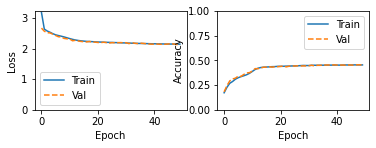

In [30]:
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(history.epoch, history.history[metric],  label='Train')
  plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.8,1])
  else:
    plt.ylim([0,1])

  plt.legend()

